# Audio Waveform and Mel-Spectrogram Visualization
This notebook demonstrates how to visualize an audio waveform and its corresponding Mel-spectrogram using the NSynth dataset and torchaudio library. The steps involved are as follows:

1. **Instantiate the Raw Dataset**: Load the 'training/validation/testing' split of the NSynth dataset without any transformation.
2. **Instantiate the MelSpectrogram Transformation**: Define the parameters for converting the audio waveform into a Mel-spectrogram.
3. **Select an Example**: Choose an example from the dataset to visualize.
4. **Plot the Waveform**: Visualize the raw audio waveform.
5. **Apply the MelSpectrogram Transformation**: Convert the waveform into a Mel-spectrogram.
6. **Convert to Decibels**: Optionally, convert the Mel-spectrogram to decibels for better visualization.
7. **Plot the Mel-Spectrogram**: Visualize the Mel-spectrogram in decibels.

__init__ took 0.0708 seconds to complete.
torch.Size([1, 64000])


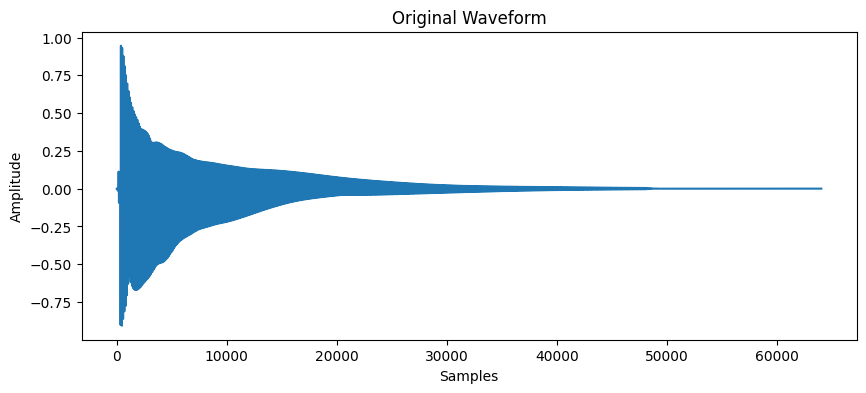

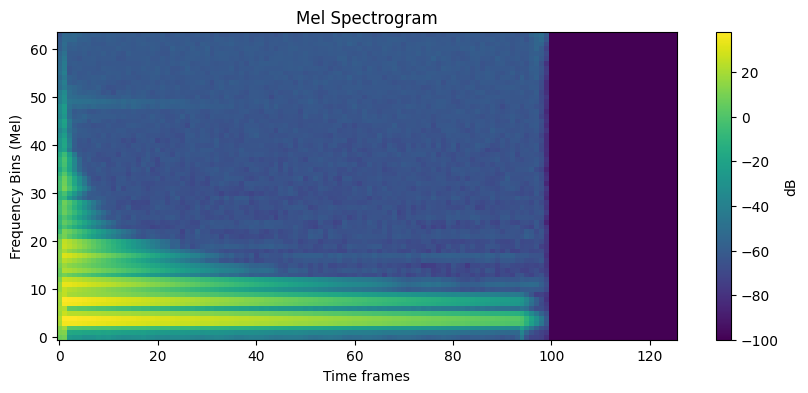

In [34]:
%run init_notebook.py

import torchaudio
from src.dataset import NSynth
from torchaudio.transforms import MelSpectrogram
from src.utils.audio_plotting import *

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Visualization of an audio waveform without transformation, and its Mel-spectrogram
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# 1) Instantiate the raw dataset
raw_dataset = NSynth('testing', transform=None)

# 2) Instantiate the MelSpectrogram transformation
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

# 3) Select an index to view an example
metadata, waveform, sample_rate = raw_dataset[0]  # example of index 0
# waveform.shape -> [1, num_samples], since it is mono
print(waveform.shape)

# 4) Plot waveform
plot_waveform(waveform)

# 5) Apply the transformation to obtain the spectrogram
mel_spec = mel_transform(waveform)  # Returns [1, n_mels, time_frames]

# 6) Convert to decibels for better visualization
db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
mel_spec_db = db_transform(mel_spec)

# 7) Plot the Mel-spectrogram
plot_spectogram(mel_spec_db)